In [ ]:
import numpy as np
import os
import torch
import itertools
import sys

current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

from retnet import RetNet,RetNetConfig
    
class rnaret_rri_model(torch.nn.Module): 
    def __init__(self, args):
        super(rnaret_rri_model, self).__init__()
        self.ret = RetNet(args)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(384,384),
            torch.nn.Tanh(),
            torch.nn.Linear(384, 2)
        )

    def forward(self, x): 
        _,aux  = self.ret(x)
        x = aux['inner_states'][-1]
        rttn = aux['rttn'][-1]
        x = x[:,0,:]
        return x, rttn
     
    
class rri_tokenizer():
    def __init__(self, k, max_len):
        self.k = k
        self.max_len = max_len
        
    def read(self, file_path):
        miRNA = []
        mRNA = []
        labels = []
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                line = line.strip()
                parts = line.split()
                miRNA.append(parts[1][::-1])
                mRNA.append(parts[3])
                labels.append(int(parts[4]))       
        return miRNA,mRNA,labels
        
    def tokenize(self, seq1, seq2):
        kmer_list = np.array([''.join(p) for p in itertools.product('ATCG', repeat=self.k)])
        kmer_to_index = {kmer: idx + 6 for idx, kmer in enumerate(kmer_list)}
        seq1, seq2 = seq1.upper(), seq2.upper()
        seq1, seq2 = seq1.replace('U','T'), seq2.replace('U','T')
        seq1_len, seq2_len = len(seq1), len(seq2)
        
        tokens = np.zeros(self.max_len, dtype=np.int16)
        
        kmers1 = np.array([seq1[i:i+self.k] for i in range(seq1_len - self.k + 1)])
        kmers2 = np.array([seq2[i:i+self.k] for i in range(seq2_len - self.k + 1)])
        
        indices1 = np.array([kmer_to_index.get(kmer, 2) for kmer in kmers1])
        indices2 = np.array([kmer_to_index.get(kmer, 2) for kmer in kmers2])
        
        tokens[:self.k//2] = 1
        tokens[self.k//2:self.k//2+len(indices1)] = indices1
        tokens[self.k//2+len(indices1):self.k-1+len(indices1)] = 1
        tokens[self.k-1+len(indices1)] = 3
        tokens[self.k+len(indices1):self.k+len(indices1)+self.k//2] = 1
        tokens[self.k+len(indices1)+self.k//2:self.k+len(indices1)+len(indices2)+self.k//2] = indices2
        tokens[self.k+len(indices1)+len(indices2)+self.k//2:2*self.k+len(indices1)+len(indices2)-1] = 1
        
        tokens = np.insert(tokens, 0, 3)

        return tokens
    
class rri_dataset(torch.utils.data.Dataset):
    def __init__(self, file, k, max_len):
        self.tokenizer = rri_tokenizer(k=k, max_len=max_len)
        self.miRNA, self.mRNA, self.labels = self.tokenizer.read(file)

    def __len__(self):
        return len(self.miRNA)

    def __getitem__(self, idx):
        seq = self.tokenizer.tokenize(self.miRNA[idx],self.mRNA[idx])
        label = self.labels[idx]
        return seq, label
    
class just_a_dataset(torch.utils.data.Dataset):
    def __init__(self, file, k, max_len):
        self.tokenizer = rri_tokenizer(k=k, max_len=max_len)
        self.miRNA, self.mRNA, self.labels = self.tokenizer.read(file)

    def __len__(self):
        return len(self.miRNA)

    def __getitem__(self, idx):
        seq1, seq2 = self.miRNA[idx],self.mRNA[idx]
        label = self.labels[idx]
        return seq1,seq2, label


In [30]:
device = torch.device('cpu')
k = 5
    
model_config = RetNetConfig(
    vocab_size=4**k+6,
    retnet_embed_dim=384,
    retnet_value_embed_dim=512,
    retnet_ffn_embed_dim=512,
    retnet_layers=8,
    retnet_retention_heads=4,
    dropout=0.2,
    activation_dropout=0.2,
    rttn_required = True
)

model1 = rnaret_rri_model(model_config)
total_params = sum(p.numel() for p in model1.parameters())
model2 = rnaret_rri_model(model_config)
model3 = rnaret_rri_model(model_config)
model1.load_state_dict(torch.load(f'../model/rri/MirTar_{k}mer.pth',weights_only=True))
model2.ret.load_state_dict(torch.load(f'../model/pretrain/pretrain_{k}mer.pth',map_location=device))
model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)
model1.eval()
model2.eval()
model3.eval()

/tmp/ipykernel_29048/764795554.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.ret.load_state_dict(torch.load(f'../model/pretrain/pretrain_{k}mer.pth',map_locati

rnaret_rri_model(
  (ret): RetNet(
    (dropout_module): Dropout(p=0.2, inplace=False)
    (embed_tokens): Embedding(1030, 384, padding_idx=0)
    (output_projection): Linear(in_features=384, out_features=1030, bias=False)
    (layers): ModuleList(
      (0-7): 8 x RetNetLayer(
        (dropout_module): Dropout(p=0.2, inplace=False)
        (retention): MultiScaleRetention(
          (q_proj): Linear(in_features=384, out_features=384, bias=False)
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=512, bias=False)
          (g_proj): Linear(in_features=384, out_features=512, bias=False)
          (out_proj): Linear(in_features=512, out_features=384, bias=False)
          (group_norm): RMSNorm()
        )
        (retention_layer_norm): RMSNorm()
        (ffn): GLU(
          (activation_dropout_module): Dropout(p=0.2, inplace=False)
          (dropout_module): Dropout(p=0.2, inplace=False)
          (fc1): L

In [ ]:
dataset = just_a_dataset('../data/data_DeepMirTar_miRAW_noRepeats_3folds_test.txt', max_len=80, k=k)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

rttn_list = []
label_list = []
model1.eval()
for seq1, seq2, label in dataloader:
    with torch.no_grad():
        seq1 = seq1[0]
        seq2 = seq2[0]
        seq = rri_tokenizer(k=k,max_len=80).tokenize(seq1,seq2)
        seq = torch.tensor(seq).unsqueeze(0).to(torch.int32).to(device)
        prob, rttn = model1(seq)
        rttn = rttn[:,:,:80,:80]
        rttn_list.append(rttn)
        label_list.append(label)
    

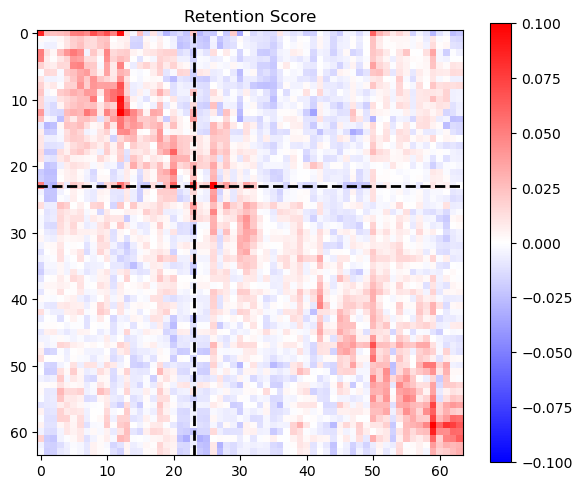

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import torch


stacked_rttn = torch.stack(rttn_list)

average_rttn = stacked_rttn.mean(dim=0)

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap',
    ['blue', 'white', 'red'],
    N=256
)
custom_cmap.set_bad(color='white') 

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

channel_data_list_pos = []

for i in range(4):
    channel_data_pos = average_rttn[0, i, :len(seq1)+len(seq2)+2, :len(seq1)+len(seq2)+2].cpu().numpy()
    channel_data_list_pos.append(channel_data_pos)

average_channel_data_pos = np.mean(channel_data_list_pos, axis=0)

im_pos = ax.imshow(average_channel_data_pos, cmap=custom_cmap, interpolation='nearest',vmax=0.1,vmin=-0.1)
fig.colorbar(im_pos, ax=ax)
ax.set_title('Retention Score', fontsize=12)

ax.axhline(y=len(seq1)+1, color='black', linewidth=2, linestyle='--')
ax.axvline(x=len(seq1)+1, color='black', linewidth=2, linestyle='--')

plt.tight_layout()

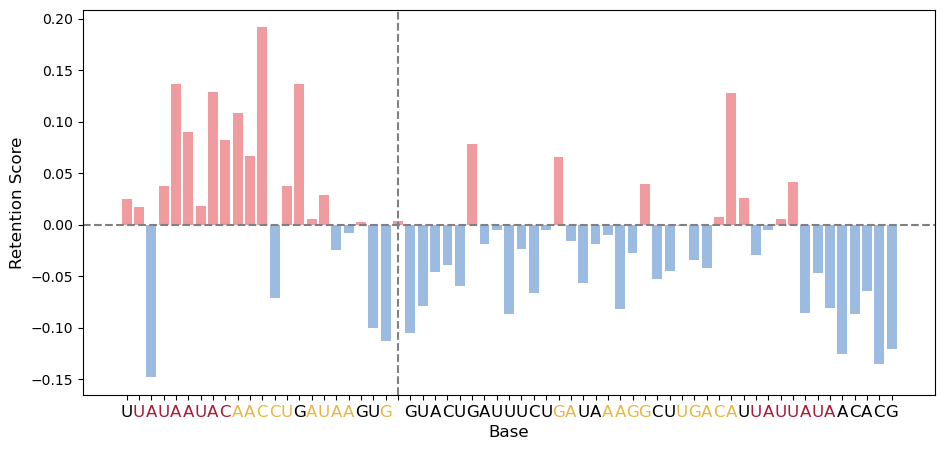

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(11, 5))
seq2 = seq2.replace('T','U')

data = channel_data_pos[0,1:]
x = np.arange(len(seq1)+len(seq2)+1)

positive_mask = data >= 0
negative_mask = data < 0

plt.bar(x[positive_mask], data[positive_mask], color='#F09BA0')
plt.bar(x[negative_mask], data[negative_mask], color='#9BBBE1')

plt.axhline(y=0, color='gray', linestyle='--')

plt.axvline(x=len(seq1), color='gray', linestyle='--')

plt.xlabel('Base', fontsize=12)
plt.ylabel('Retention Score', fontsize=12)
labels = list(seq1) + [' '] + list(seq2)
plt.xticks(x, labels, fontsize=12)
highlight_indices = list(range(1,9)) + list(range(51,58))
for i, label in enumerate(plt.gca().get_xticklabels()):
    if i in highlight_indices:
        label.set_color('#A51C36')
highlight_indices = [9,10,11,12,13,15,16,17,18,21,22] + [49,48,47,46,45,42,41,40,39,36,35]
for i, label in enumerate(plt.gca().get_xticklabels()):
    if i in highlight_indices:
        label.set_color('#E6B745')        

plt.savefig("rri_cls.pdf", format='pdf',bbox_inches='tight')

In [ ]:
dataset = rri_dataset('../data/data_DeepMirTar_miRAW_noRepeats_3folds_test.txt', max_len=80, k=k)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

emb_dict1 = []
emb_dict2 = []
emb_dict3 = []
label_dict = []

for i, (x, y) in enumerate(dataloader):
    x = x.to(torch.long).to(device)
    y = y.to(torch.long).to(device)
    prob1, _ = model1(x)
    prob2, _ = model2(x)
    prob3, _ = model3(x)
    prob1 = prob1.squeeze(0).detach().cpu().numpy()
    prob2 = prob2.squeeze(0).detach().cpu().numpy()
    prob3 = prob3.squeeze(0).detach().cpu().numpy()
    
    label = y.item() 
    emb_dict1.append(prob1)
    emb_dict2.append(prob2)
    emb_dict3.append(prob3)
    label_dict.append(label)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

embeddings1 = np.array(emb_dict1)
embeddings2 = np.array(emb_dict2)
embeddings3 = np.array(emb_dict3)
labels = np.array(label_dict)

pca = PCA(n_components=2) 
reduced_embeddings1 = pca.fit_transform(embeddings1)
reduced_embeddings2 = pca.fit_transform(embeddings2)
reduced_embeddings3 = pca.fit_transform(embeddings3)

In [ ]:
colors = ['#1868B2', '#DE582B']  
cmap = ListedColormap(colors)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = axs[0].scatter(reduced_embeddings1[:, 0], reduced_embeddings1[:, 1], c=labels, cmap=cmap, alpha=0.7, s=2)
axs[0].set_title('Fine-Tuned', fontsize=15)
axs[0].set_xlabel('PC1', fontsize=12)
axs[0].set_ylabel('PC2', fontsize=12)
legend1 = axs[0].legend(handles=scatter1.legend_elements()[0], labels=['Negative', 'Positive'], title="Interaction",loc='upper right')

scatter2 = axs[1].scatter(reduced_embeddings2[:, 0], reduced_embeddings2[:, 1], c=labels, cmap=cmap, alpha=0.7, s=2)
axs[1].set_title('Pretrained', fontsize=15)
axs[1].set_xlabel('PC1', fontsize=12)
axs[1].set_ylabel('PC2', fontsize=12)
legend2 = axs[1].legend(handles=scatter2.legend_elements()[0], labels=['Negative', 'Positive'], title="Interaction",loc='upper right')

scatter3 = axs[2].scatter(reduced_embeddings3[:, 0], reduced_embeddings3[:, 1], c=labels, cmap=cmap, alpha=0.7, s=2)
axs[2].set_title('Random', fontsize=15)
axs[2].set_xlabel('PC1', fontsize=12)
axs[2].set_ylabel('PC2', fontsize=12)
legend3 = axs[2].legend(handles=scatter3.legend_elements()[0], labels=['Negative', 'Positive'], title="Interaction",loc='upper right')

plt.tight_layout()

plt.savefig("rri_cluster.pdf", format='pdf',bbox_inches='tight')